下载和缓存数据集
首先，我们维护字典DATA_HUB，其将数据集名称的字符串映射到数据集相关的二元组上，这个二元组包含数据集的url和验证文件完整性的sha-1密钥。所有这样的数据集都托管在地址为DATA_URL的站点上。

In [7]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

download函数用来下载数据集，将数据集缓存在本地目录（默认情况下为../data）中，并返回下载文件的名称。如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配，我们将使用缓存的文件，以避免重复的下载。

In [13]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

实现了两个额外的实用函数：一个是下载并解压缩一个zip或tar文件，另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [14]:
def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder)if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)
        

访问和读取数据集

In [26]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv', '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv', 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [27]:
print(train_data.shape)
print(test_data.shape)
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])#iloc可以查看csv文件的具体内容

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [28]:
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


在每个样本之中，第一个特征是ID,它不携带任何预测的信息，所以将数据提供给模型之前，将其从数据集中删除

In [29]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
#pd.concat将两个矩阵以行相加的形式进行拼接,将训练集减去id和目标值，测试集减去目标值，先用iloc选中，再用concat拼接

数据预处理，首先将所有缺失的值替换为相应特征的平均值。
然后，为了将所有特征放在一个共同的尺度上，我们通过将特征重新缩放到零均值和单位方差来标准化数据
我们标准化数据有两个原因。首先，它方便优化。其次，因为我们不知道哪些特征是相关的，所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。

In [30]:
#将非字符串的特征（数值类型）取出来放在numeric_features
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index#dtype返回数据元素的数据类型（int、float等）
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean())/ (x.std()))#将数值特征的均值变成0方差变成1
#lambda ：相当于函数的定义，类似构造匿名函数f()
#在标准化数据之后，将缺失值全部fill（填充）为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来，我们处理离散值。这包括诸如“MSZoning”之类的特征。我们用一次独热编码替换它们，方法与前面将多类别标签转换为向量的方式相同(请参见 3.4.1节 )。例如，“MSZoning”包含值“RL”和“Rm”。将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。根据独热编码，如果“MSZoning”的原始值为“RL”，则:“MSZoning_RL”为1，“MSZoning_RM”为0。pandas软件包会自动为我们实现这一点。

In [31]:
# `Dummy_na=True` 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征(如果有缺失值就再增加一个特征，缺失就填入1，不缺失就填入0)
all_features = pd.get_dummies(all_features, dummy_na=True)#pd.get_dummies是实现one hot encode的方式
all_features.shape

(2919, 331)

此转换会将特征的数量从79个增加到331个。最后，通过values属性，我们可以从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练。

In [34]:
n_train = train_data.shape[0]#取训练集中样本的个数—shape[0]取得的是csv的行数
#对于图像来说shape[0]，shape[1]，shape[2]分别代表的是图像的垂直高度，水平宽度，通道数；对于matrix来说shape[0]，shape[1]分别代表的是matrix的行与列
train_features = torch.tensor(all_features[:n_train].values, dtype=d2l.float32)#torch.tensor(xxxx.values)-这样就可以将matrix转换成为一个矩阵
#all_features[:n_train].values是一个numpy的结构，现在要将其变成一个tensor
test_features = torch.tensor(all_features[n_train:].values, dtype=d2l.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=d2l.float32)
#reshape(-1, 1)：将“整个”matrix变成列;reshape(1, -1)：将“整个”matrix变成行

训练，训练一个带有损失平方的线性模型
我们的线性模型不会让我们在竞赛中获胜，但线性模型提供了一种健全性检查，以查看数据中是否存在有意义的信息。如果我们在这里不能做得比随机猜测更好，那么我们很可能存在数据处理错误。如果一切顺利，线性模型将作为基线模型，让我们直观地知道简单的模型离报告最好的模型有多近，让我们感觉到我们应该从更酷炫的模型中获得多少收益。

In [35]:
loss = nn.MSELoss()
in_features = train_features.shape[1]#取特征数（列）

def get_net():#一个单层的线性回归网络
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

我们更关心相对误差(y−y^)/y，而不是绝对误差y−y^.要取预测价格的对数与真实标签价格的对数之间出现的均方根误差：

In [36]:
def log_rmse(net, features, labels):
    """为了在取对数时进一步稳定该值，将小于1的值设置为1"""
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
#torch.clamp(input, min, max, out=None)—Tensor 将输入input张量每个元素的夹紧到区间[min,max]，并返回结果到一个新张量。 
#在这里就是将net的输出夹紧到[1,正无穷]，不然等下求log的时候会出现问题
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

与前面的部分不同，我们的训练函数将借助Adam优化器（我们将在后面更详细地描述它）。这个优化器的主要吸引力在于，尽管在提供无限资源进行超参数优化方面没有做得更好（有时更差），但人们发现它对初始学习率不那么敏感。

In [37]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate,
          weight_decay,batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))#.append()在列表末尾添加新的对象
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

K折交叉验证。这有助于模型选择和超参数调整
我们首先需要一个函数，在K折交叉验证过程中返回第i折的数据。它选择第i个切片作为验证数据，其余部分作为训练数据。注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，我们肯定会做一些更聪明的改变。但是这种改变所增加的复杂性可能会使代码看起来更乱。在这里可以忽略这些改变，因为我们的问题很简单。

In [44]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k#“/”表示浮点除法“//”表示整数除法，向下取整
    X_train, y_train = None, None
    for j in range(k):
        #slice() 函数实现切片对象，主要用在切片操作函数里的参数传递
        idx = slice(j * fold_size, (j + 1) * fold_size)#训练集被分为k折，每折的大小是fold_size，我们要将每折取出来就要用到slice
        X_part,y_part, = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
            #torch.cat是将两个张量（tensor）拼接在一起，(A,B),0：按行拼接（要求列数同）；(A,B),1：按列拼接
    return X_train, y_train, X_valid, y_valid

当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值。

In [47]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0 ,0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse',
                     xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f},'
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k



模型选择
在本例中，我们选择了一组未调优的超参数，并将其留给读者来改进模型。找到一个好的选择可能需要时间，这取决于一个人优化了多少变量。有了足够大的数据集和合理设置的超参数，K折交叉验证往往对多次测试具有相当的适应性。然而，如果我们尝试了不合理的大量选项，我们可能会发现验证效果不再代表真正的误差。

fold 1, train log rmse 0.871856,valid log rmse 0.882164
fold 2, train log rmse 0.871079,valid log rmse 0.884277
fold 3, train log rmse 0.870902,valid log rmse 0.886125
fold 4, train log rmse 0.877960,valid log rmse 0.853213
fold 5, train log rmse 0.873403,valid log rmse 0.877568
5-折验证: 平均训练log rmse: 0.873040, 平均验证log rmse: 0.876669


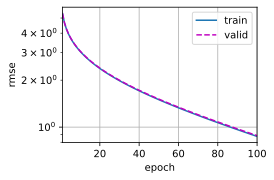

In [51]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 1, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

提交你的Kaggle预测

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_szie):
    net = get_bet()
    train_ls, _=train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    